# Homework Assignment 6

Programming assignment to create, train, and test a CNN for the task of object classification. 

In this assignment, I am running Tensorflow on local GPU+CPU using PrettyTensor library for easier implementation. 

## A brief description of the program

This program builds, trains, and classifies image classes for CIFAR-10 dataset. 

It begins by using the parameters specified in HW6, and was tuned to improve accuracy. 

For intermediate results, please see the notebook contents below. 


## Summary and discussion of the results

The program achieves a 77.3% accuracy after ~130,000 iterations. Please see below for details. 

### Accuracy on test set
77.3% (7733 / 10000)

### Accuracy by each class
```
airplane 81.6%
automobile 90.1%
bird 68.4%
cat 43.7%
deer 70.8%
dog 76.1%
frog 90.6%
horse 81.1%
ship 81.8%
truck 89.1%
```

### Confusion Matrix
```
[816  21  42  15   7   7  16  10  31  35] (0) airplane
[  8 901   4   2   1   2  13   0   8  61] (1) automobile
[ 51   9 684  40  36  53  83  34   6   4] (2) bird
[ 17  12  38 437  53 238 141  29   9  26] (3) cat
[ 22   4  65  23 708  35  57  74   7   5] (4) deer
[  6   7  35  64  31 761  44  38   3  11] (5) dog
[  5   7  25  13  18  17 906   3   2   4] (6) frog
[ 13   3  21  19  38  57  17 811   2  19] (7) horse
[ 78  29   7   7   1   3  11   2 818  44] (8) ship
[ 18  46   6   7   2   2  11   7  10 891] (9) truck
 (0) (1) (2) (3) (4) (5) (6) (7) (8) (9)
(10, 10)
```

### Adjusting the number of layer 1 and 2

With 6 convolutional filters in the first layer and 16 convolution filters in the second layer, I was able to get a ~70% accuracy on the test data set. To improve the accuracy, I've increased the number of filters (depth) in the first layer from 6 to 32, and depth in the second layer from 16 to 64. 


### Cropping to 24x24
The homework mentions cropping the original images to 24x24 dimension from left-right top-bottom corners. Instead of using the corners, TensorFlow's `random_crop` function was used to randomly crop the images. This provides better randomization of the cropping process. 

### Additional pre-processing of the images
Hue, saturation, contrast were randomly adjusted with TensorFlow's built-in functions. 

### Normalize pixel values
Instead of subtracting the mean of the images, the pixel values were normalized between (0, 1). 

### Rank-5 was applicable due to small number of classes
Rank-5 was able to improve the accuracy by a very large margin (using `tf.nn.in_top_k()`), the number of classes were too small to utilize this method. Note that this would be applicable when the number of classes are much larger (at least a 1000). 

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math
import os

# Use PrettyTensor to simplify Neural Network construction
import prettytensor as pt

In [2]:
tf.__version__

'1.4.0'

In [3]:
pt.__version__

'0.7.4'

## Homework specifications

Below are homework 6 specifications from Dr. Nevatia. 

I have initially tried 100,000 iterations with the exact specifications listed in the assignment, but was only able to get ~70% accuracy. 

Initial run with given HW6 default parameters
```
=====================================================
Global step:  100000, Training Batch Accuracy:  71.1%
Saved checkpoint
Duration: 3:20:09
=====================================================
```

Results on test set with HW6 default parameters
```
=====================================================
Accuracy on test set: 70.2% (7022 / 10000)
=====================================================
```

From the lectures, it was suggested that the smaller kernels and 

In [4]:
# HW6 specifications
conv1_kernel = 5                 # originally 5
conv1_depth = 32                 # originall 6
conv1_stride = 1                 # originally 1
maxpool1_kernel = 2              # originally 2
conv2_kernel = 5                 # originally 5
conv2_depth = 64                 # originall 16
conv2_stride = 1                 # originally 2
maxpool2_kernel = 2              # originally 2
fc1_dimension = 120              # originally 120
fc2_dimension = 84               # originally 84
train_batch_size = 64            # mini batch size of 64 as recommended
learning_rate = 0.001            # learning rate
activation_function = tf.nn.relu # All activation units should be ReLU
img_size_cropped = 24            # will be used to randomly crop images to 24x24

## Load Cifar-10 Data

Let's first load Cifar-10 data using a pre-coded script

In [5]:
import cifar10

The CIFAR-10 dataset will be downloaded with the code below. 

In [6]:
cifar10.maybe_download_and_extract()

Data has apparently already been downloaded and unpacked.


Load the class names. 

In [7]:
class_names = cifar10.load_class_names()
class_names

Loading data: data/CIFAR-10/cifar-10-batches-py/batches.meta


['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

Load the training-set. This returns the images, the class numbers (as integers), and the class numbers as One_Hot encoded arrays called labels. 

In [8]:
images_train, cls_train, labels_train = cifar10.load_training_data()

Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_1
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_2
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_3
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_4
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_5


Let's load the test-set (similar to loading the training set). 

In [9]:
images_test, cls_test, labels_test = cifar10.load_test_data()

Loading data: data/CIFAR-10/cifar-10-batches-py/test_batch


The CIFAR-10 dataset now has been loaded with 60,000 images and labels. 
Let's check if we have the correct number of training and test images. 

In [10]:
print("Training set: " + str(len(images_train)) + " images, Test set: " + str(len(images_test)) + " images")

Training set: 50000 images, Test set: 10000 images


### Data Dimensions

These are helper variables that will be later used in the Tensorflow Code. 

In [11]:
from cifar10 import img_size, num_channels, num_classes

## Plot Images

Just a helper function to plot 9 images with matplotlib. 

In [12]:
def plot_images(images, cls_true, cls_pred=None, smooth=True):
    
    assert len(images) == len(cls_true) == 9
    
    # Create figure with sub-plots
    fig, axes = plt.subplots(3, 3)
    
    # Adjust vertical spacing if we need to print ensemble and best-net
    if cls_pred is None:
        hspace = 0.3
    else:
        hspace = 0.6
    
    fig.subplots_adjust(hspace=hspace, wspace=0.3)
    
    for i, ax in enumerate(axes.flat):
        # Interpolation type
        if smooth: 
            interpolation = 'spline16'
        else: 
            interpolation = 'nearest'
            
        # Plot image
        ax.imshow(images[i, :, :, :], 
                interpolation=interpolation)
        
        # Name of the true class
        cls_true_name = class_names[cls_true[i]]
        
        # Show true and predicted classes
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true_name)
        else:
            # Name of the predicted class
            xlabel = "True: {0}\nPred: {1}".foramt(cls_true_name, cls_pred_name)
           
        # Show the classes as the label on the x-axis
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot
        ax.set_xticks([])
        ax.set_yticks([])
        
    # show plot
    plt.show()

#### Check if plotting images work

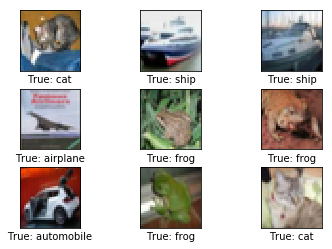

In [13]:
# Get the first images from the test set
images = images_test[0:9]

# Get the true classes for these images
cls_true = cls_test[0:9]

# Plot the images and labels using our helper-function above
plot_images(images=images, cls_true=cls_true, smooth=False)

## Create placeholder variables for images, labels, and class numbers

In [14]:
x = tf.placeholder(tf.float32, shape=[None, img_size, img_size, num_channels], name='x')
y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')
y_true_cls = tf.argmax(y_true, axis=1)

## Image pre-processing functions

- Subtract mean of the images
- 

In [15]:
def pre_process_image(image, training):
    # Take a single image as an input, 
    # and a boolean whether to build the training or testing graph
    
    if training:
        image = tf.random_crop(image, size=[img_size_cropped, img_size_cropped, num_channels]) 
        
        # Randomly flip the image horizontally
        image = tf.image.random_flip_left_right(image)
        
        # These parts are optional
        image = tf.image.random_hue(image, max_delta=0.05)
        image = tf.image.random_contrast(image, lower=0.3, upper=1.0)
        image = tf.image.random_brightness(image, max_delta=0.2)
        image = tf.image.random_saturation(image, lower=0.0, upper=2.0)
        
        # Prevent pixel underflow/overflow
        image = tf.minimum(image, 1.0)
        image = tf.maximum(image, 0.0)
    
    else:
        image = tf.image.resize_image_with_crop_or_pad(image, 
                                                        target_height=img_size_cropped, 
                                                       target_width=img_size_cropped)
        
    return image

Map to lambda function for all images

In [16]:
def pre_process(images, training):
    images = tf.map_fn(lambda image : pre_process_image(image, training), images)
    
    return images

To plot the distorted images, we create the pre-processing graph for TensorFlow, so we may execute it later.

In [17]:
distorted_images = pre_process(images=x, training=True)

## Main neural network

In [18]:
def main_network(images, training):
    # Wrap the input images as a Pretty Tensor object
    x_pretty = pt.wrap(images)
    
    # Pretty Tensor uses special numbers to distinguish between the training and testing phases
    if training:
        phase = pt.Phase.train
    else:
        phase = pt.Phase.infer
        
    # Create our CNN
    with pt.defaults_scope(activation_fn=activation_function, phase=phase):
        y_pred, loss = x_pretty\
            .conv2d(kernel=conv1_kernel, depth=conv1_depth, stride=(conv1_stride,conv1_stride), name='layer_conv1')\
            .max_pool(kernel=maxpool1_kernel, stride=maxpool1_kernel)\
            .conv2d(kernel=conv2_kernel, depth=conv2_depth, stride=(conv2_stride,conv2_stride), name='layer_conv2')\
            .max_pool(kernel=maxpool2_kernel, stride=maxpool2_kernel)\
            .flatten()\
            .fully_connected(size=fc1_dimension, name='layer_fc1')\
            .fully_connected(size=fc2_dimension, name='layer_fc2')\
            .softmax_classifier(num_classes=num_classes, labels=y_true)
            
    return y_pred, loss

## Helper function to create a neural network

In [19]:
def create_network(training):
    with tf.variable_scope('network', reuse=not training):
        images = x
        
        images = pre_process(images=images, training=training)
        
        # Create a TensorFlow graph for the main network
        y_pred, loss = main_network(images=images, training=training)
        
    return y_pred, loss

## Neural network for training phase

Let's create a tensorflow variable that keeps track of the number of optimization iterations. This is a TensorFlow variable that will be saved at different checkpoints.

In [20]:
global_step = tf.Variable(initial_value=0, name='global_step', trainable=False)

Let's create the neural network for training. 

In [21]:
_, loss = create_network(training=True)

Let's create an ADAM optimizer with a learning rate of 0.001. 

In [22]:
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss, global_step=global_step)

## Neural network for test phase

Let's create the neural network for the test-phase. 

In [23]:
y_pred, _ = create_network(training=False)

Pick the predicted class with argmax

In [24]:
y_pred_cls = tf.argmax(y_pred, axis=1)

Create a vector of correct/incorrect classification results

In [25]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls)

Calculate accuracy by typecasting booleans to floats, and taking average of the numbers. 

In [26]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

## Save variables

Save the tensorflow train/graph variables. 

In [27]:
saver = tf.train.Saver()

## Run TensorFlow session

In [28]:
session = tf.Session()

### Saving session variables into checkpoints

In [29]:
save_dir = 'checkpoints/'

if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    
save_path = os.path.join(save_dir, 'cifar10_cnn')

Try restoring last checkpoint

In [30]:
try:
    print('Trying to restore last checkpoint...')
    
    # Find the latest checkpoint
    last_check_path = tf.train.latest_checkpoint(checkpoint_dir=save_dir)
    
    # Try and loading the data
    saver.restore(session, save_path=last_check_path)
    
    # Print results if successful
    print('Restored checkpoint from ', last_check_path)

except:
    print('No checkpoint to restore from, will initialize variables instead')
    session.run(tf.global_variables_initializer())

Trying to restore last checkpoint...
No checkpoint to restore from, will initialize variables instead


## Get random mini batch for training

In [31]:
def random_batch():
    num_images = len(images_train)
    
    # Create a random index
    idx = np.random.choice(num_images, 
                           size=train_batch_size, 
                          replace=False)
    
    # Use the random index to select random batch
    x_batch = images_train[idx, :, :, :]
    y_batch = labels_train[idx, :]
    
    return x_batch, y_batch

## Perform optimization

In [32]:
def optimize(num_iterations):
    start_time = time.time()
    
    for i in range(num_iterations): 
        # Get a random batch
        x_batch, y_true_batch = random_batch()
        
        # Convert to a dict to pass to TensorFlow
        feed_dict_train = {
            x: x_batch, 
            y_true: y_true_batch
        }
        
        # Run the optimizer using this batch
        # Retrieve the global step counter
        i_global, _ = session.run([global_step, optimizer],
                                 feed_dict=feed_dict_train)
        
        # Print status to screen every 100 iterations and last
        if (i_global % 100 == 0) or (i == num_iterations - 1):
            # Calculate the accuracy on the training-batch
            batch_accuracy = session.run(accuracy,
                                        feed_dict=feed_dict_train)
            
            # Print status
            msg = 'Global step: {0:>6}, Training Batch Accuracy: {1:>6.1%}'
            print(msg.format(i_global, batch_accuracy))
            
        # Save a checkpoint every 1000 iterations and last
        if (i_global % 1000 == 0) or (i == num_iterations - 1):
            saver.save(session,
                      save_path=save_path,
                      global_step=global_step)
            
            print("Saved checkpoint")
            
    end_time = time.time()
    
    time_diff = end_time - start_time
    
    print("Duration: " + str(timedelta(seconds=int(round(time_diff)))))

## Calculate classificiations

Calculate the predicted classes of images and return a boolean array whether the classification of each imaage is correct. 

In [49]:
# Split to batches
batch_size = 256

def predict_cls(images, labels, cls_true):
    # Number of images
    num_images = len(images)
    
    cls_pred = np.zeros(shape=num_images, dtype=np.int)
    
    start_index = 0
    
    while start_index < num_images:
        end_index = min(start_index + batch_size, num_images)
        
        feed_dict = {
            x: images[start_index:end_index, :], 
            y_true: labels[start_index:end_index, :]
        }
        
        cls_pred[start_index:end_index] = session.run(y_pred_cls, feed_dict=feed_dict)
        
        # Set the start index for the next batch to the end index of the current batch
        start_index = end_index
        
    # A boolean array of whether each image is correctly classified
    correct = (cls_true == cls_pred)
    
    # in case using a rank-5
    # correct = tf.nn.in_top_k(cls_pred, range(10), 5)
        
    return correct, cls_pred

Calculate the predicted classes of test set. 
We won't be using batches here. 

In [34]:
def predict_cls_test():
    return predict_cls(images=images_test,
                      labels=labels_test,
                      cls_true=cls_test)

## Classification accuracy and confusion matrix

In [35]:
def classification_accuracy(correct):
    # Accuracy and number of accurate scores
    return correct.mean(), correct.sum()

In [50]:
def plot_confusion_matrix(cls_pred):
    cm = confusion_matrix(y_true=cls_test, 
                         y_pred=cls_pred)
    
    for i in range(num_classes):
        class_name = "({}) {}".format(i, class_names[i])
        print(cm[i, :], class_name)
    
    # Print the class-numbers for easy reference
    class_numbers = [" ({0})".format(i) for i in range(num_classes)]
    print("".join(class_numbers))
    
    return cm

In [90]:
def print_test_accuracy():
    correct, cls_pred = predict_cls_test()
    
    acc, num_correct = classification_accuracy(correct)
    
    num_images = len(correct)
    
    msg = 'Accuracy on test set: {0:.1%} ({1} / {2})'
    print(msg.format(acc, num_correct, num_images))
    
    print("Confusion Matrix:")
    cm = plot_confusion_matrix(cls_pred=cls_pred)
    
    print(cm.shape)
    
    index = 0 
    
    print("")
    print("Accuracy by each class")
    for row in cm:
        print('{} {:.1%}'.format(class_names[index], row[index] / 1000))
        
        index += 1

## Start!

In [44]:
# num_iterations refers to the number of ADDITIONAL iterations to run (not from 0)
optimize(num_iterations=100)

Global step: 131100, Training Batch Accuracy:  85.9%
Global step: 131188, Training Batch Accuracy:  81.2%
Saved checkpoint
Duration: 0:00:10


## Results

In [91]:
print_test_accuracy()

Accuracy on test set: 77.3% (7733 / 10000)
Confusion Matrix:
[816  21  42  15   7   7  16  10  31  35] (0) airplane
[  8 901   4   2   1   2  13   0   8  61] (1) automobile
[ 51   9 684  40  36  53  83  34   6   4] (2) bird
[ 17  12  38 437  53 238 141  29   9  26] (3) cat
[ 22   4  65  23 708  35  57  74   7   5] (4) deer
[  6   7  35  64  31 761  44  38   3  11] (5) dog
[  5   7  25  13  18  17 906   3   2   4] (6) frog
[ 13   3  21  19  38  57  17 811   2  19] (7) horse
[ 78  29   7   7   1   3  11   2 818  44] (8) ship
[ 18  46   6   7   2   2  11   7  10 891] (9) truck
 (0) (1) (2) (3) (4) (5) (6) (7) (8) (9)
(10, 10)

Accuracy by each class
airplane 81.6%
automobile 90.1%
bird 68.4%
cat 43.7%
deer 70.8%
dog 76.1%
frog 90.6%
horse 81.1%
ship 81.8%
truck 89.1%
